In [ ]:
import pandas as pd
from pandas import read_excel
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from keras.models import model_from_json
import tensorflow as tf
from sklearn.utils import class_weight
from google.colab import drive

In [ ]:
import pickle
from pprint import pprint
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import roc_auc_score, average_precision_score, plot_roc_curve 

In [ ]:
drive.mount("/content/gdrive")

tf.test.gpu_device_name()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


'/device:GPU:0'

In [ ]:
location = "/content/gdrive/My Drive/Colab Notebooks/MultiModal_PD/"

# **Extra Preprocessing**

---



In [ ]:
df = pd.read_csv(location + "clinical_masterDB.csv", sep=",")
df.head(5)

,PATNO,First_Fam_Num,First_Fam_PD,Other_Fam_Num,Other_Fam_PD,GENDER,ENROLLDT,AGE,HISPLAT,RAINDALS,RAASIAN,RABLACK,RAHAWOPI,RAWHITE,RANOS,MDS_UPDRS1,MDS_UPDRS2,MDS_UPDRS3,Unadjusted_MOCA,Socio_Score,MOCA,TREMOR,PIGD,BJLO,ESS,SLEEPINESS,GDS,DEPRESSION,HVLT_RECALL,HVLT_RECOG,HVLT_RETENT,LNS,QUIP_SEC_A,QUIP_SEC_B,QUIP_SEC_C,QUIP_SEC_D,QUIP_SEC_E,RBDSQ,RBD_STATUS,SCOPA_TOTAL,SCOPA_GASTRO,SCOPA_URINARY,SCOPA_CARDIO,SCOPA_THERMO,SCOPA_PUPIL,SCOPA_SEXUAL,SFT,STAI,UPSIT,STATUS
0,3000.0,5.0,0.0,12.0,0.0,0,02/2011,69,0.0,0.0,0.0,0.0,0.0,1.0,0.0,6.321429,0.000000,6.000000,28.000000,18.0,28.000000,0.075000,0.000000,14.250000,5.000000,Not Sleepy,0.500000,Not Depressed,28.125,9.125000,0.917647,11.875000,0,0,0,0,0,2,Negative,6.125000,0.625000,3.750000,0.000000,0.000000,0.000000,1.750000,56.500000,60.625000,35.0,0
1,3001.0,6.0,0.0,15.5,0.0,1,03/2011,65,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.250000,4.687500,28.500000,29.500000,16.0,29.500000,1.895000,0.131250,14.250000,5.888889,Not Sleepy,1.666667,Not Depressed,26.875,10.125000,1.012658,15.125000,0,1,0,0,1,12,Positive,15.444444,2.555556,6.888889,0.555556,1.000000,0.111111,4.333333,46.875000,61.666667,21.0,1
2,3002.0,6.0,0.0,16.0,0.0,0,03/2011,67,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.812500,15.375000,25.869565,27.375000,16.0,27.375000,1.163587,1.225996,12.625000,13.666667,Sleepy,5.333333,Depressed,25.875,9.500000,1.012346,10.500000,0,0,0,1,2,11,Positive,24.555556,8.111111,7.777778,0.222222,4.666667,2.555556,1.222222,46.125000,79.222222,14.5,1
3,3003.0,4.0,0.0,6.0,0.0,0,04/2011,56,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.375000,7.875000,40.444444,27.375000,16.0,27.375000,1.605556,1.159722,13.375000,7.333333,Not Sleepy,1.111111,Not Depressed,26.125,11.375000,0.896552,9.125000,0,0,0,1,0,8,Positive,15.555556,2.666667,9.888889,1.777778,0.888889,0.222222,0.111111,46.875000,47.111111,18.5,1
4,3004.0,5.0,0.0,8.0,0.0,1,04/2011,59,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.714286,0.428571,3.857143,27.428571,16.0,27.428571,0.000000,0.000000,14.142857,8.285714,Not Sleepy,1.000000,Not Depressed,21.000,11.571429,0.750000,11.285714,0,0,0,0,1,3,Negative,6.571429,1.571429,2.857143,0.000000,0.714286,0.000000,1.428571,53.571429,54.285714,37.5,0


In [ ]:
print(len(df.columns))

50


1.   Converted **SLEEPINESS, DEPRESSION, RBD_STATUS** into binary and checked correlations: They are not necessary hence remove
2.   Remove **PATNO, ENROLLDT, RAHAWOPI (only value present is 0)**
3. Binary Variables: **GENDER, HISPLAT, RAINDALS, RAASIAN, RABLACK, RAWHITE, RANOS**







In [ ]:
df = df.drop(columns = ["PATNO", "ENROLLDT", "RAHAWOPI", "SLEEPINESS", "DEPRESSION", "RBD_STATUS", "GENDER", "HISPLAT"
                        ,"RAINDALS", "RAASIAN", "RABLACK", "RAWHITE", "RANOS", 
                        "MDS_UPDRS1", "MDS_UPDRS2", "MDS_UPDRS3", 
                        # "SCOPA_TOTAL", "SCOPA_GASTRO", "SCOPA_URINARY", "SCOPA_CARDIO", "SCOPA_THERMO", "SCOPA_PUPIL", "SCOPA_SEXUAL",
                        # "First_Fam_Num", "First_Fam_PD", "Other_Fam_Num", "Other_Fam_PD", "AGE", 
                        # "Socio_Score", 
                        "MOCA","Unadjusted_MOCA", 
                        # "BJLO",	"ESS", "GDS", "HVLT_RECALL", "HVLT_RECOG", "HVLT_RETENT", "LNS", "QUIP_SEC_A", "QUIP_SEC_B", "QUIP_SEC_C", "QUIP_SEC_D",	"QUIP_SEC_E", 	
                        # "RBDSQ", "SFT", "STAI", 
                        # "UPSIT",
                        "TREMOR", "PIGD"
                        ], axis = 1)
df.head()

,First_Fam_Num,First_Fam_PD,Other_Fam_Num,Other_Fam_PD,AGE,Socio_Score,BJLO,ESS,GDS,HVLT_RECALL,HVLT_RECOG,HVLT_RETENT,LNS,QUIP_SEC_A,QUIP_SEC_B,QUIP_SEC_C,QUIP_SEC_D,QUIP_SEC_E,RBDSQ,SCOPA_TOTAL,SCOPA_GASTRO,SCOPA_URINARY,SCOPA_CARDIO,SCOPA_THERMO,SCOPA_PUPIL,SCOPA_SEXUAL,SFT,STAI,UPSIT,STATUS
0,5.0,0.0,12.0,0.0,69,18.0,14.250000,5.000000,0.500000,28.125,9.125000,0.917647,11.875000,0,0,0,0,0,2,6.125000,0.625000,3.750000,0.000000,0.000000,0.000000,1.750000,56.500000,60.625000,35.0,0
1,6.0,0.0,15.5,0.0,65,16.0,14.250000,5.888889,1.666667,26.875,10.125000,1.012658,15.125000,0,1,0,0,1,12,15.444444,2.555556,6.888889,0.555556,1.000000,0.111111,4.333333,46.875000,61.666667,21.0,1
2,6.0,0.0,16.0,0.0,67,16.0,12.625000,13.666667,5.333333,25.875,9.500000,1.012346,10.500000,0,0,0,1,2,11,24.555556,8.111111,7.777778,0.222222,4.666667,2.555556,1.222222,46.125000,79.222222,14.5,1
3,4.0,0.0,6.0,0.0,56,16.0,13.375000,7.333333,1.111111,26.125,11.375000,0.896552,9.125000,0,0,0,1,0,8,15.555556,2.666667,9.888889,1.777778,0.888889,0.222222,0.111111,46.875000,47.111111,18.5,1
4,5.0,0.0,8.0,0.0,59,16.0,14.142857,8.285714,1.000000,21.000,11.571429,0.750000,11.285714,0,0,0,0,1,3,6.571429,1.571429,2.857143,0.000000,0.714286,0.000000,1.428571,53.571429,54.285714,37.5,0


In [ ]:
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,First_Fam_Num,First_Fam_PD,Other_Fam_Num,Other_Fam_PD,AGE,Socio_Score,BJLO,ESS,GDS,HVLT_RECALL,HVLT_RECOG,HVLT_RETENT,LNS,QUIP_SEC_A,QUIP_SEC_B,QUIP_SEC_C,QUIP_SEC_D,QUIP_SEC_E,RBDSQ,SCOPA_TOTAL,SCOPA_GASTRO,SCOPA_URINARY,SCOPA_CARDIO,SCOPA_THERMO,SCOPA_PUPIL,SCOPA_SEXUAL,SFT,STAI,UPSIT,STATUS
0,6.0,0.0,6.0,0.0,52,12.0,13.000000,6.857143,0.714286,27.333333,10.666667,0.910448,14.500000,0,0,0,1,0,7,12.571429,1.714286,7.857143,0.571429,0.571429,0.428571,1.428571,60.166667,53.428571,20.0,1
1,7.0,0.0,11.0,0.0,54,18.0,12.625000,3.625000,0.375000,31.375000,9.500000,0.833333,10.000000,0,0,0,0,1,6,5.375000,0.250000,3.250000,0.000000,1.000000,0.125000,0.750000,52.875000,47.750000,34.5,0
2,9.0,0.0,13.0,1.0,60,18.0,12.857143,9.625000,7.500000,30.000000,9.571429,0.916667,11.000000,0,0,0,1,1,9,14.250000,4.875000,4.125000,0.875000,3.625000,0.625000,0.125000,63.142857,91.125000,18.0,1
3,10.0,0.0,18.0,0.0,61,26.0,14.555556,2.900000,0.800000,24.222222,10.444444,0.892857,9.666667,0,0,0,0,0,11,9.500000,1.500000,6.800000,0.200000,0.400000,0.200000,0.400000,50.222222,47.000000,18.5,1
4,6.0,0.0,11.0,0.0,62,17.0,13.333333,11.000000,3.000000,23.333333,10.000000,0.655172,9.333333,0,1,0,0,0,11,16.500000,5.000000,9.000000,0.750000,1.750000,0.000000,0.000000,63.000000,78.000000,15.0,1


# **XGBoost Feature Selection**

---

In [ ]:
print(len(df))

input_columns=len(df.columns)-1
output_columns=1

X = df.iloc[:, 0:input_columns]
y = df.iloc[:, -1]

682


25
SCOPA_TOTAL      0.147114
UPSIT            0.145473
SCOPA_GASTRO     0.095747
SCOPA_CARDIO     0.064404
First_Fam_PD     0.046161
SCOPA_THERMO     0.045985
Other_Fam_PD     0.034289
GDS              0.033960
AGE              0.033045
LNS              0.028540
SCOPA_PUPIL      0.028328
ESS              0.027724
First_Fam_Num    0.026703
STAI             0.025523
BJLO             0.025045
SCOPA_SEXUAL     0.024189
HVLT_RETENT      0.023387
RBDSQ            0.020904
HVLT_RECOG       0.020236
HVLT_RECALL      0.019175
SFT              0.018406
Socio_Score      0.017588
SCOPA_URINARY    0.017442
Other_Fam_Num    0.017169
QUIP_SEC_E       0.013462
dtype: float32


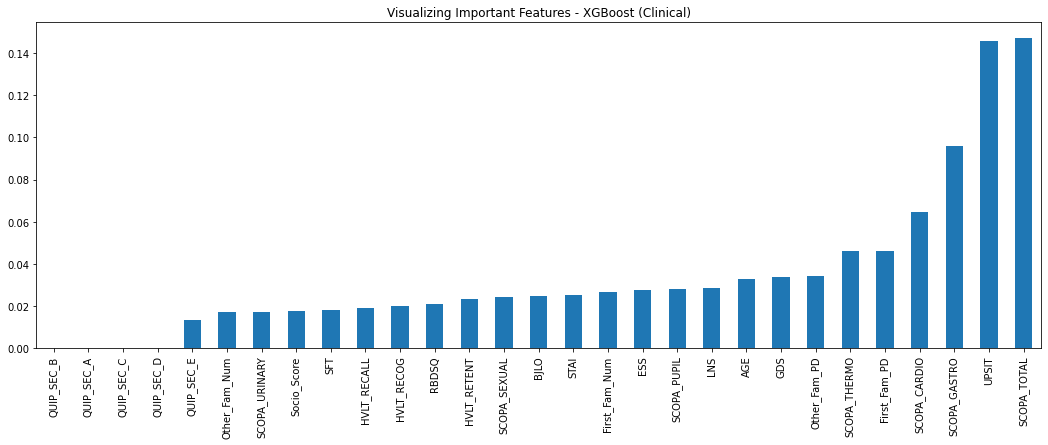

In [ ]:
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X, y)

feature_imp = pd.Series(xgb_clf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(len(feature_imp[feature_imp>0]))
print(feature_imp[feature_imp>0])

feature_imp.sort_values().tail(30).plot(kind = 'bar', figsize = (18,6))
plt.title("Visualizing Important Features - XGBoost (Clinical)")
plt.show()

feaSel_xgb = list(feature_imp[feature_imp>0].index)

In [ ]:
file = location + "feaSel_xgb_Clin.txt"
with open(file, 'w') as file:
        for row in feaSel_xgb:
            s = "".join(map(str, row))
            file.write(s+'\n')

# **ML Models**

---



In [ ]:
print(len(df.columns))
print(df.columns)

30
Index(['First_Fam_Num', 'First_Fam_PD', 'Other_Fam_Num', 'Other_Fam_PD', 'AGE',
       'Socio_Score', 'BJLO', 'ESS', 'GDS', 'HVLT_RECALL', 'HVLT_RECOG',
       'HVLT_RETENT', 'LNS', 'QUIP_SEC_A', 'QUIP_SEC_B', 'QUIP_SEC_C',
       'QUIP_SEC_D', 'QUIP_SEC_E', 'RBDSQ', 'SCOPA_TOTAL', 'SCOPA_GASTRO',
       'SCOPA_URINARY', 'SCOPA_CARDIO', 'SCOPA_THERMO', 'SCOPA_PUPIL',
       'SCOPA_SEXUAL', 'SFT', 'STAI', 'UPSIT', 'STATUS'],
      dtype='object')


In [ ]:
print(len(df))
# print(train_length, val_length)

input_columns=len(df.columns)-1
output_columns=1

682


In [ ]:
train_length = int(0.8*len(df))
test_length = int(0.2*len(df))+1
print(train_length, test_length)

545 137


In [ ]:
# dataset = df.values
X = df.iloc[:train_length,0:input_columns]
y = df.iloc[:train_length, -1]

X_test = df.iloc[train_length: (train_length + test_length), 0:input_columns]
y_test = df.iloc[train_length: (train_length + test_length), -1]

Train Data distribtuion:
PD    388
HC    157
Name: STATUS, dtype: int64


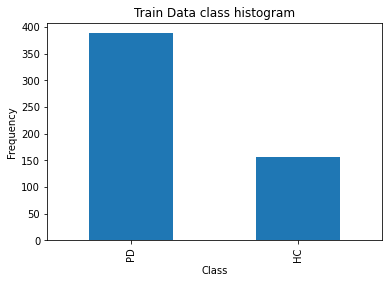

In [ ]:
# Train data distribution
count_classes = y.replace({0:"HC", 1:"PD"}).value_counts()
print("Train Data distribtuion:")
print(count_classes)
plt.title("Train Data class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency") 
count_classes.plot(kind = 'bar')

Test Data distribtuion:
PD    98
HC    39
Name: STATUS, dtype: int64


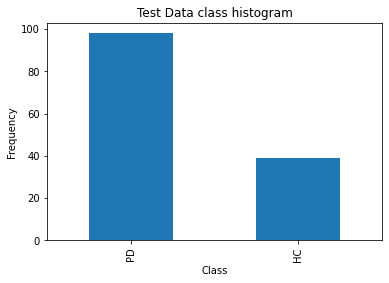

In [ ]:
# Test data distribution
count_classes = y_test.replace({0:"HC", 1:"PD"}).value_counts()
print("Test Data distribtuion:")
print(count_classes)
plt.title("Test Data class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency") 
count_classes.plot(kind = 'bar')

In [ ]:
scalarX = MinMaxScaler() # Normalising
scalarX.fit(X)

X = scalarX.transform(X)
X_test = scalarX.transform(X_test)

## **Random Forest**

---

In [ ]:
clf = RandomForestClassifier()

# # Parameters used by our current forest
# print('Parameters initial\n')
# pprint(clf.get_params())

#Setting the range for class weights
weights = np.linspace(0.5,0.99,50)


# specify parameters and distributions to sample from
hp = {'bootstrap': [True, False],
      'criterion': ['gini', 'entropy'],
      # 'n_estimators': [10, 25], 
      # 'max_features': [5, 10], 
      # 'max_depth': [10, 50, None], 
      'max_depth': np.arange(5, 10, 1),
      'max_features': [5, 6, 7],
      # 'min_samples_leaf': [0, 1, 2, 3, 4, 5],
      # 'min_samples_split': [1, 2, 5, 10],
      'n_estimators': np.arange(10, 500, 10),
      'warm_start': [True, False],
      'class_weight': [{0:x, 1:1.0-x} for x in weights]
      }
# pprint(hp)

# run randomized search
print("\nStarting randomized search\n")
n_iter_search = 250
n_jobs_val = -1
random_search = RandomizedSearchCV(clf, 
                                    param_distributions=hp,
                                    n_iter=n_iter_search,
                                    cv=StratifiedKFold(),
                                    verbose = 5,
                                    scoring='roc_auc',
                                    return_train_score = True,
                                    n_jobs = n_jobs_val)

#Train the model using the training sets y_pred=clf.predict(X_test)
random_search.fit(X,y)

pprint(random_search.best_estimator_)
pprint(random_search.best_params_)
pd.DataFrame(random_search.cv_results_)

print("\nSaving model\n")

clf = random_search.best_estimator_

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X,y)

# save the model to disk
filename = location + 'clin_RF_1' + '.sav'
pickle.dump(clf, open(filename, 'wb'))


Starting randomized search

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 878 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1148 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 1250 out of 1250 | elapsed:  8.4min finished


RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight={0: 0.65, 1: 0.35}, criterion='gini',
                       max_depth=6, max_features=7, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=240, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=True)
{'bootstrap': False,
 'class_weight': {0: 0.65, 1: 0.35},
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': 7,
 'n_estimators': 240,
 'warm_start': True}

Saving model



/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:359: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


AUC-ROC =  0.9107796964939822
AUC-PR =  0.9592950739126924
F1 score =  0.8877005347593584
Precision =  0.9325842696629213
Recall =  0.8469387755102041
              precision    recall  f1-score   support

           0       0.69      0.85      0.76        39
           1       0.93      0.85      0.89        98

    accuracy                           0.85       137
   macro avg       0.81      0.85      0.82       137
weighted avg       0.86      0.85      0.85       137



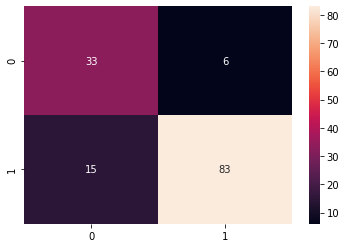

In [ ]:
# load the model from disk
filename = location + 'clin_RF' + '.sav'
clf = pickle.load(open(filename, 'rb'))
clf_rf = clf


y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:,1]

print("AUC-ROC = ", roc_auc_score(y_test, y_pred_proba))
print("AUC-PR = ", average_precision_score(y_test, y_pred_proba))
print("F1 score = ", f1_score(y_test, y_pred))
print("Precision = ", precision_score(y_test, y_pred))
print("Recall = ", recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

#Ploting the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)
plt.show()

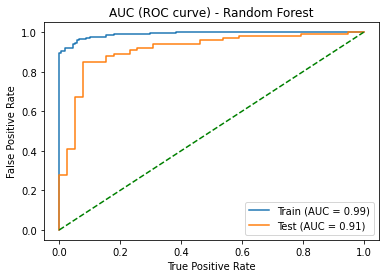

In [ ]:
ax = plt.gca()
X_list = [X, X_test]
y_list = [y, y_test]
name_list = ["Train", "Test"]

for i in range(2):
    plot_roc_curve(clf, X_list[i], y_list[i], name=name_list[i], ax=ax) 
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("AUC (ROC curve) - Random Forest")
plt.show()

## **Gaussian Naive Bayes**

---

In [ ]:
clf = GaussianNB()
 
# # Parameters used by our current forest
# print('Parameters initial\n')
# pprint(clf.get_params())
 
# specify parameters and distributions to sample from
hp = {'var_smoothing': np.logspace(0,-9, num=50)}
# pprint(hp)
 
# run randomized search
print("\nStarting randomized search\n")
n_iter_search = 200
n_jobs_val = -1
random_search = RandomizedSearchCV(clf, 
                                    param_distributions=hp,
                                    n_iter=n_iter_search, 
                                    cv=StratifiedKFold(),
                                    verbose = 5, 
                                    scoring='roc_auc',
                                    return_train_score = True,
                                    n_jobs = n_jobs_val)
 
#Train the model using the training sets y_pred=clf.predict(X_test)
random_search.fit(X,y)
 
pprint(random_search.best_estimator_)
pprint(random_search.best_params_)
pd.DataFrame(random_search.cv_results_)
 
print("\nSaving model\n")
 
clf = random_search.best_estimator_
 
#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X,y)
 
# save the model to disk
filename = location + 'clin_GNB' + '.sav'
pickle.dump(clf, open(filename, 'wb'))


Starting randomized search

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 50 is smaller than n_iter=200. Running 50 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    0.2s


GaussianNB(priors=None, var_smoothing=0.004094915062380423)
{'var_smoothing': 0.004094915062380423}

Saving model



[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.9s finished


AUC-ROC =  0.8631606488749345
AUC-PR =  0.9436217235498789
F1 score =  0.7954545454545455
Precision =  0.8974358974358975
Recall =  0.7142857142857143
              precision    recall  f1-score   support

           0       0.53      0.79      0.63        39
           1       0.90      0.71      0.80        98

    accuracy                           0.74       137
   macro avg       0.71      0.75      0.71       137
weighted avg       0.79      0.74      0.75       137



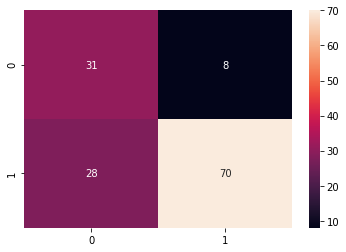

In [ ]:
# load the model from disk
filename = location + 'clin_GNB' + '.sav'
clf = pickle.load(open(filename, 'rb'))
clf_gnb = clf

y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:,1]

print("AUC-ROC = ", roc_auc_score(y_test, y_pred_proba))
print("AUC-PR = ", average_precision_score(y_test, y_pred_proba))
print("F1 score = ", f1_score(y_test, y_pred))
print("Precision = ", precision_score(y_test, y_pred))
print("Recall = ", recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

#Ploting the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)
plt.show()

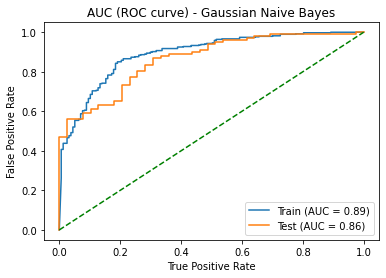

In [ ]:
ax = plt.gca()
X_list = [X, X_test]
y_list = [y, y_test]
name_list = ["Train", "Test"]

for i in range(2):
    plot_roc_curve(clf, X_list[i], y_list[i], name=name_list[i], ax=ax) 
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("AUC (ROC curve) - Gaussian Naive Bayes")
plt.show()

## **SVM**

---

In [ ]:
clf = SVC()

# # Parameters used by our current forest
# print('Parameters initial\n')
# pprint(clf.get_params())

# specify parameters and distributions to sample from
hp = {'C': [0.0001, 0.001, 0.01, 0.1, 0, 1, 10, 25, 50, 75, 100],
      'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
      'gamma': ['scale', 'auto'],
      'shrinking': [True, False],
      'class_weight': [{0:x, 1:1.0-x} for x in weights],
      # 'decision_function_shape': ['ovo', 'ovr']
      }
# pprint(hp)

# run randomized search
print("\nStarting randomized search\n")
n_iter_search = 150
n_jobs_val = -1
random_search = RandomizedSearchCV(clf, 
                                    param_distributions=hp,
                                    n_iter=n_iter_search, 
                                    cv=StratifiedKFold(),
                                    verbose = 5, 
                                    scoring='roc_auc',
                                    return_train_score = True,
                                    n_jobs = n_jobs_val)

#Train the model using the training sets y_pred=clf.predict(X_test)
random_search.fit(X,y)

pprint(random_search.best_estimator_)
pprint(random_search.best_params_)
pd.DataFrame(random_search.cv_results_)

print("\nSaving model\n")

clf = random_search.best_estimator_

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X,y)

# save the model to disk
filename = location + 'clin_SVM' + '.sav'
pickle.dump(clf, open(filename, 'wb'))


Starting randomized search

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 476 tasks      | elapsed:    6.7s


SVC(C=1, break_ties=False, cache_size=200,
    class_weight={0: 0.5590954773869347, 1: 0.44090452261306534}, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=False,
    tol=0.001, verbose=False)
{'C': 1,
 'class_weight': {0: 0.5590954773869347, 1: 0.44090452261306534},
 'gamma': 'auto',
 'kernel': 'linear',
 'shrinking': False}

Saving model



[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:   10.1s finished


AUC-ROC =  0.8771585557299842
AUC-PR =  0.9553494006131074
F1 score =  0.922279792746114
Precision =  0.9368421052631579
Recall =  0.9081632653061225
              precision    recall  f1-score   support

           0       0.79      0.85      0.81        39
           1       0.94      0.91      0.92        98

    accuracy                           0.89       137
   macro avg       0.86      0.88      0.87       137
weighted avg       0.89      0.89      0.89       137



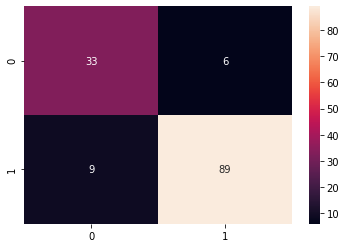

In [ ]:
# load the model from disk
filename = location + 'clin_SVM' + '.sav'
clf = pickle.load(open(filename, 'rb'))
clf_svm = clf

y_pred = clf.predict(X_test)

fpr, tpr, _ = roc_curve(y_test, y_pred)
print("AUC-ROC = ", auc(fpr,tpr))
prec, rec, thresholds = precision_recall_curve(y_test, y_pred)
print("AUC-PR = ", auc(rec, prec))
print("F1 score = ", f1_score(y_test, y_pred))
print("Precision = ", precision_score(y_test, y_pred))
print("Recall = ", recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


#Ploting the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)
plt.show()

SVC(C=1, break_ties=False, cache_size=200,
    class_weight={0: 0.5590954773869347, 1: 0.44090452261306534}, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=False,
    tol=0.001, verbose=False)


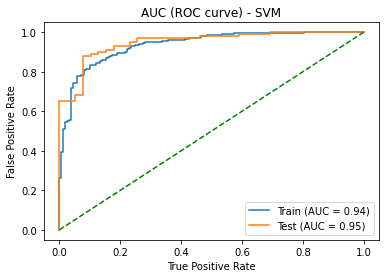

In [ ]:
ax = plt.gca()
X_list = [X, X_test]
y_list = [y, y_test]
name_list = ["Train", "Test"]

print(clf)

for i in range(2):
  plot_roc_curve(clf, X_list[i], y_list[i], name=name_list[i], ax=ax) 
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("AUC (ROC curve) - SVM")
plt.show()

## **Logistic Regression**

---

In [ ]:
clf = LogisticRegression()

# # Parameters used by our current forest
# print('Parameters initial\n')
# pprint(clf.get_params())

# specify parameters and distributions to sample from
hp = {'C': [0.0001, 0.001, 0.01, 0.1, 0, 1, 10, 25, 50, 75, 100],
      'penalty': ['l1', 'l2', 'elasticnet'],
      'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
      'class_weight': [{0:x, 1:1.0-x} for x in weights],
      'multi_class': ['multinomial', 'ovr', 'auto'],
      'warm_start': [True, False],
      'l1_ratio': np.arange(0, 1.1, 0.1),
      'random_state': [81]
      }
# pprint(hp)

# run randomized search
print("\nStarting randomized search\n")
n_iter_search = 500
n_jobs_val = -1
random_search = RandomizedSearchCV(clf, 
                                    param_distributions=hp,
                                    n_iter=n_iter_search, 
                                    cv=StratifiedKFold(),
                                    verbose = 5, 
                                    scoring='roc_auc',
                                    return_train_score = True,
                                    n_jobs = n_jobs_val)

#Train the model using the training sets y_pred=clf.predict(X_test)
random_search.fit(X,y)

pprint(random_search.best_estimator_)
pprint(random_search.best_params_)
pd.DataFrame(random_search.cv_results_)

print("\nSaving model\n")

clf = random_search.best_estimator_

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X,y)

# save the model to disk
filename = location + 'clin_logReg' + '.sav'
pickle.dump(clf, open(filename, 'wb'))


Starting randomized search

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1660 tasks      | elapsed:    9.5s


LogisticRegression(C=10,
                   class_weight={0: 0.6378894472361809, 1: 0.3621105527638191},
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=0.4, max_iter=100, multi_class='ovr', n_jobs=None,
                   penalty='l1', random_state=81, solver='liblinear',
                   tol=0.0001, verbose=0, warm_start=True)
{'C': 10,
 'class_weight': {0: 0.6378894472361809, 1: 0.3621105527638191},
 'l1_ratio': 0.4,
 'multi_class': 'ovr',
 'penalty': 'l1',
 'random_state': 81,
 'solver': 'liblinear',
 'warm_start': True}

Saving model



[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:   14.1s finished
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


AUC-ROC =  0.9510727367870225
AUC-PR =  0.9811363991119363
F1 score =  0.900523560209424
Precision =  0.9247311827956989
Recall =  0.8775510204081632
              precision    recall  f1-score   support

           0       0.73      0.82      0.77        39
           1       0.92      0.88      0.90        98

    accuracy                           0.86       137
   macro avg       0.83      0.85      0.84       137
weighted avg       0.87      0.86      0.86       137



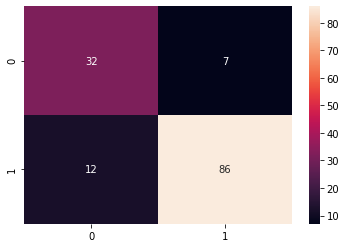

In [ ]:
# load the model from disk
filename = location + 'clin_logReg' + '.sav'
clf = pickle.load(open(filename, 'rb'))
clf_logReg = clf

y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:,1]

print("AUC-ROC = ", roc_auc_score(y_test, y_pred_proba))
print("AUC-PR = ", average_precision_score(y_test, y_pred_proba))
print("F1 score = ", f1_score(y_test, y_pred))
print("Precision = ", precision_score(y_test, y_pred))
print("Recall = ", recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

#Ploting the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)
plt.show()

LogisticRegression(C=10,
                   class_weight={0: 0.6378894472361809, 1: 0.3621105527638191},
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=0.4, max_iter=100, multi_class='ovr', n_jobs=None,
                   penalty='l1', random_state=81, solver='liblinear',
                   tol=0.0001, verbose=0, warm_start=True)


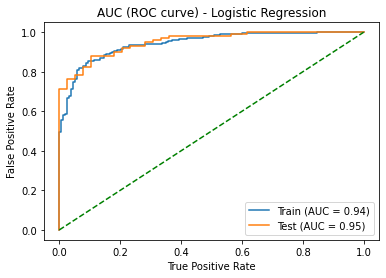

In [ ]:
ax = plt.gca()
X_list = [X, X_test]
y_list = [y, y_test]
name_list = ["Train", "Test"]

print(clf)

for i in range(2):
  plot_roc_curve(clf, X_list[i], y_list[i], name=name_list[i], ax=ax) 
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("AUC (ROC curve) - Logistic Regression")
plt.show()

## **Stochastic Gradient Descent**

---

In [ ]:
clf = SGDClassifier()

# # Parameters used by our current forest
# print('Parameters initial\n')
# pprint(clf.get_params())

# specify parameters and distributions to sample from
hp = {'alpha': [0.0001, 0.001, 0.01, 0.1,0.15,0.2,0.5,0.8,1],
      'l1_ratio': [0,0.1,0.15,0.18,0.2,0.3],
      'loss': ['log'],
      'class_weight': [{0:x, 1:1.0-x} for x in weights],
      'random_state': [81],
      'tol': [None]
      }
# pprint(hp)

# run randomized search
print("\nStarting randomized search\n")
n_iter_search = 500
n_jobs_val = -1
random_search = RandomizedSearchCV(clf, 
                                    param_distributions=hp,
                                    n_iter=n_iter_search, 
                                    cv=StratifiedKFold(),
                                    verbose = 5, 
                                    scoring='roc_auc',
                                    return_train_score = True,
                                    n_jobs = n_jobs_val)

#Train the model using the training sets y_pred=clf.predict(X_test)
random_search.fit(X,y)

pprint(random_search.best_estimator_)
pprint(random_search.best_params_)
pd.DataFrame(random_search.cv_results_)

print("\nSaving model\n")

clf = random_search.best_estimator_

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X,y)

# save the model to disk
filename = location + 'clin_SGD' + '.sav'
pickle.dump(clf, open(filename, 'wb'))


Starting randomized search

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 564 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done 888 tasks      | elapsed:   56.1s
[Parallel(n_jobs=-1)]: Done 1284 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1752 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 2292 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  2.6min finished


SGDClassifier(alpha=0.0001, average=False,
              class_weight={0: 0.5049246231155778, 1: 0.49507537688442216},
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.18, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=81, shuffle=True, tol=None, validation_fraction=0.1,
              verbose=0, warm_start=False)
{'alpha': 0.0001,
 'class_weight': {0: 0.5049246231155778, 1: 0.49507537688442216},
 'l1_ratio': 0.18,
 'loss': 'log',
 'random_state': 81,
 'tol': None}

Saving model



AUC-ROC =  0.9476713762428048
AUC-PR =  0.9788409953672383
F1 score =  0.9175257731958762
Precision =  0.9270833333333334
Recall =  0.9081632653061225
              precision    recall  f1-score   support

           0       0.78      0.82      0.80        39
           1       0.93      0.91      0.92        98

    accuracy                           0.88       137
   macro avg       0.85      0.86      0.86       137
weighted avg       0.89      0.88      0.88       137



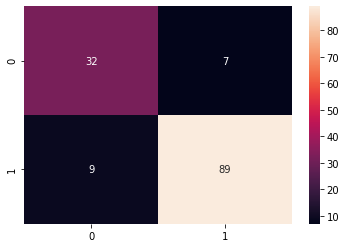

In [ ]:
# load the model from disk
filename = location + 'clin_SGD' + '.sav'
clf = pickle.load(open(filename, 'rb'))
clf_SGD = clf

y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:,1]

print("AUC-ROC = ", roc_auc_score(y_test, y_pred_proba))
print("AUC-PR = ", average_precision_score(y_test, y_pred_proba))
print("F1 score = ", f1_score(y_test, y_pred))
print("Precision = ", precision_score(y_test, y_pred))
print("Recall = ", recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

#Ploting the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)
plt.show()

SGDClassifier(alpha=0.0001, average=False,
              class_weight={0: 0.5049246231155778, 1: 0.49507537688442216},
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.18, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=81, shuffle=True, tol=None, validation_fraction=0.1,
              verbose=0, warm_start=False)


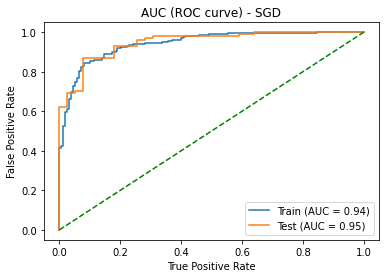

In [ ]:
ax = plt.gca()
X_list = [X, X_test]
y_list = [y, y_test]
name_list = ["Train", "Test"]

print(clf)

for i in range(2):
  plot_roc_curve(clf, X_list[i], y_list[i], name=name_list[i], ax=ax) 
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("AUC (ROC curve) - SGD")
plt.show()

## **ROC Curve**

---

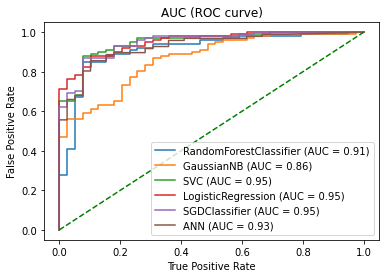

In [ ]:
ax = plt.gca()
classifiers = [clf_rf, clf_gnb, clf_svm, clf_logReg, clf_SGD]

for i in classifiers:
    plot_roc_curve(i, X_test, y_test, ax=ax)
plt.plot(fpr_test, tpr_test, label='ANN (AUC = {:.2f})'.format(auc_test))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("AUC (ROC curve)")
plt.show()

# **ANN**

---



In [ ]:
## LOAD PRETRAINED MODEL
# choice = int(input("Do you want to load any saved model? Enter 1 for Yes and 0 for No: "))
# if(choice == 1):
    
#     acc_tr = int(input("Enter train accuracy rounded to the nearest integer: "))
#     acc_va = int(input("Enter validation accuracy rounded to the nearest integer: "))
#     file_name = location + 'models/model_Clinical' + "_" + str(acc_tr) + "_" + str(acc_va)

#     # load json and create model
#     json_file = open(file_name + '.json', 'r')
#     loaded_model_json = json_file.read()
#     json_file.close()
#     model = model_from_json(loaded_model_json)
#     # load weights into new model
#     model.load_weights(file_name + ".h5")
#     print("Loaded model from disk")

#     # evaluate loaded model on test data
#     model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])
    

Do you want to load any saved model? Enter 1 for Yes and 0 for No: 0


In case you want to check the results for this model, do not run the 3 cells corresponding to model fitting, i.e the one where model is defined, the one where training is done and the one with Loss vs epochs curves. Run everything else. Also do not save again

#### **Defining Train_data, Val_data and Test data**

---



In [ ]:
dataset = df.values

train_length = int(0.6*len(df))
val_length = int(0.2*len(df))
test_length = int(0.2*len(df))

X = dataset[:train_length,0:input_columns]
y = dataset[:train_length, -1].reshape(train_length, 1)

X_valid = dataset[train_length: (train_length + val_length), 0:input_columns]
y_valid = dataset[train_length: (train_length + val_length), -1].reshape(val_length, 1)

X_test = dataset[(train_length + val_length): (train_length + val_length + test_length), 0:input_columns]
y_test = dataset[(train_length + val_length): (train_length + val_length + test_length), -1].reshape(test_length, 1)

# USING CLASS WEIGHTS
class_weights = dict(zip(np.unique(y.flatten()), class_weight.compute_class_weight('balanced', np.unique(y.flatten()), y.flatten())))

scalarX = MinMaxScaler()
scalarX.fit(X)

X = scalarX.transform(X)
X_valid = scalarX.transform(X_valid)
X_test = scalarX.transform(X_test)

print(len(X), len(X_valid), len(X_test))

409 136 136


Train Data distribtuion:
PD    299
HC    110
Name: STATUS, dtype: int64


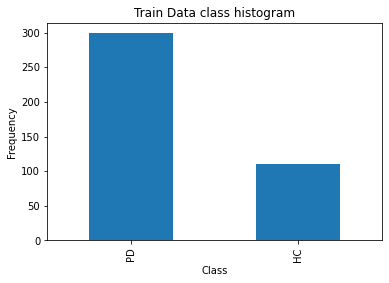

In [ ]:
# Train data distribution
count_classes = df.iloc[:train_length, -1].replace({0:"HC", 1:"PD"}).value_counts()
print("Train Data distribtuion:")
print(count_classes)
plt.title("Train Data class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency") 
count_classes.plot(kind = 'bar')

Val Data distribtuion:
PD    89
HC    47
Name: STATUS, dtype: int64


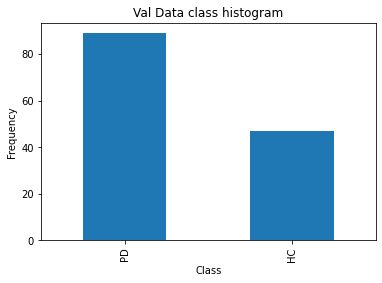

In [ ]:
# Val data distribution
count_classes = df.iloc[train_length: (train_length + val_length), -1].replace({0:"HC", 1:"PD"}).value_counts()
print("Val Data distribtuion:")
print(count_classes)
plt.title("Val Data class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency") 
count_classes.plot(kind = 'bar')

Test Data distribtuion:
1    97
0    39
Name: STATUS, dtype: int64


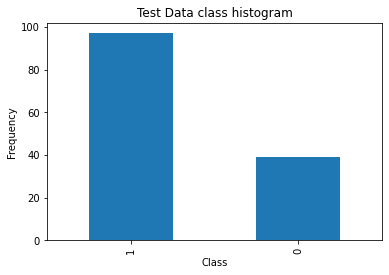

In [ ]:
# Test data distribution
count_classes = df.iloc[(train_length + val_length): (train_length + val_length + test_length), -1].value_counts()
print("Test Data distribtuion:")
print(count_classes)
plt.title("Test Data class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency") 
count_classes.plot(kind = 'bar')

# **Training the Model**

---



In [ ]:
model = Sequential()
model.add(Dense(4, input_dim=input_columns, activation='relu'))
# model.add(Dense(2, activation='relu'))
model.add(Dense(output_columns, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 120       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 125
Trainable params: 125
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
batch_size = 5
num_epoch = 50
output = model.fit(X, y, batch_size = batch_size, epochs=num_epoch, verbose=1,
                  #  class_weight=class_weights
                   validation_data=(X_valid, y_valid))

Epoch 1/50
82/82 [==============================] - 3s 4ms/step - loss: 0.5306 - val_loss: 0.6217
Epoch 2/50
82/82 [==============================] - 0s 3ms/step - loss: 0.5532 - val_loss: 0.6124
Epoch 3/50
82/82 [==============================] - 0s 3ms/step - loss: 0.5311 - val_loss: 0.5966
Epoch 4/50
82/82 [==============================] - 0s 2ms/step - loss: 0.5383 - val_loss: 0.5838
Epoch 5/50
82/82 [==============================] - 0s 3ms/step - loss: 0.5332 - val_loss: 0.5699
Epoch 6/50
82/82 [==============================] - 0s 2ms/step - loss: 0.5216 - val_loss: 0.5585
Epoch 7/50
82/82 [==============================] - 0s 2ms/step - loss: 0.5073 - val_loss: 0.5467
Epoch 8/50
82/82 [==============================] - 0s 3ms/step - loss: 0.4737 - val_loss: 0.5340
Epoch 9/50
82/82 [==============================] - 0s 2ms/step - loss: 0.4591 - val_loss: 0.5219
Epoch 10/50
82/82 [==============================] - 0s 3ms/step - loss: 0.4628 - val_loss: 0.5142
Epoch 11/50
82/82 [

<Figure size 432x288 with 0 Axes>

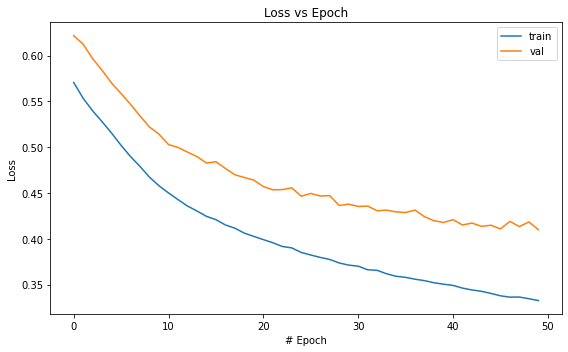

In [ ]:
fig = plt.figure()
plt.figure(figsize=(8,5))
plt.plot(output.history['loss'])
plt.plot(output.history['val_loss'])
plt.title('Loss vs Epoch')
plt.ylabel('Loss')
plt.xlabel('# Epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.tight_layout()

## **Save Model**

In [ ]:
# Saving the model
print("\nSaving model")
# serialize model to JSON
model_json = model.to_json()
with open(location + "clin_ann.json", "w") as json_file:
    json_file.write(model_json)
print("Saved model as json")
# serialize weights to HDF5
model.save_weights(location + "clin_ann_wt.h5")
print("Saved model weights")


Saving model
Saved model as json
Saved model weights


# **Model Evaluation**

---



Train AUC-ROC = 0.93
Validation AUC-ROC = 0.89
Test AUC-ROC = 0.93


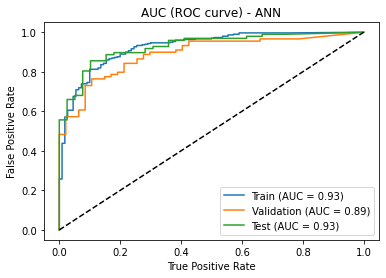

In [ ]:
pred = model.predict(X)
# train_y_pred = np.where(pred > 0.5, 1, 0)
fpr_train, tpr_train, _ = roc_curve(y, pred)
auc_train = auc(fpr_train, tpr_train).round(2)
print("Train AUC-ROC =", str(auc_train))

pred = model.predict(X_valid)
# val_y_pred = np.where(pred > 0.5, 1, 0)
fpr_val, tpr_val, _ = roc_curve(y_valid, pred)
auc_val = auc(fpr_val, tpr_val).round(2)
print("Validation AUC-ROC =", str(auc_val))

pred = model.predict(X_test)
# test_y_pred = np.where(pred > 0.5, 1, 0)
fpr_test, tpr_test, _ = roc_curve(y_test, pred)
auc_test = auc(fpr_test, tpr_test).round(2)
print("Test AUC-ROC =", str(auc_test))

plt.plot(fpr_train, tpr_train, label='Train (AUC = {:.2f})'.format(auc_train))
plt.plot(fpr_val, tpr_val, label='Validation (AUC = {:.2f})'.format(auc_val))
plt.plot(fpr_test, tpr_test, label='Test (AUC = {:.2f})'.format(auc_test))
plt.plot([0,1],[0,1],'k--')
plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("AUC (ROC curve) - ANN")
plt.show()

In [ ]:
def check_metrics(model, testX, testY):  

  pred = model.predict(testX)
  y_pred = np.where(pred > 0.5, 1, 0)
  print('##############  Confusion Matrix  ##############')
  print()
  np.set_printoptions(threshold=np.inf)
  print(confusion_matrix(testY, y_pred))
  np.set_printoptions(threshold=100)
  print()
  print('##############  Classification Report  ##############')
  print()
  print(classification_report(testY, y_pred))

In [ ]:
# X_valid = dataset[train_length: (train_length + val_length), 0:input_columns]
# y_valid = dataset[train_length: (train_length + val_length), -1 ].reshape(val_length, 1)

# X_valid = scalarX.transform(X_valid)

In [ ]:
check_metrics(model, X_valid, y_valid)

##############  Confusion Matrix  ##############

[[28 19]
 [ 8 81]]

##############  Classification Report  ##############

              precision    recall  f1-score   support

         0.0       0.78      0.60      0.67        47
         1.0       0.81      0.91      0.86        89

    accuracy                           0.80       136
   macro avg       0.79      0.75      0.77       136
weighted avg       0.80      0.80      0.79       136



In [ ]:
check_metrics(model, X, y)

##############  Confusion Matrix  ##############

[[ 76  34]
 [ 16 283]]

##############  Classification Report  ##############

              precision    recall  f1-score   support

         0.0       0.83      0.69      0.75       110
         1.0       0.89      0.95      0.92       299

    accuracy                           0.88       409
   macro avg       0.86      0.82      0.84       409
weighted avg       0.87      0.88      0.87       409



In [ ]:
check_metrics(model, X_test, y_test)

##############  Confusion Matrix  ##############

[[27 12]
 [ 7 90]]

##############  Classification Report  ##############

              precision    recall  f1-score   support

         0.0       0.79      0.69      0.74        39
         1.0       0.88      0.93      0.90        97

    accuracy                           0.86       136
   macro avg       0.84      0.81      0.82       136
weighted avg       0.86      0.86      0.86       136



# **Checking random examples**

---



In [ ]:
index = 21

testing = (X_valid[index, :]).reshape(1,input_columns)
print(testing)
pred = model.predict(testing)
print("PREDICTION BY MODEL:", pred[0])
if (pred > 0.5):
  print("CLASS IS PD")
else:
  print("CLASS IS HC")
print("TRUE VALUE:", y_valid[index])

[[0.13333333 0.         0.17857143 0.         0.55555556 0.66666667
  0.52873563 0.16666667 0.04761905 0.73713899 0.95192308 0.73723168
  0.3442623  0.         0.         0.         0.         0.
  0.30769231 0.08433735 0.14606742 0.06944444 0.         0.02941176
  0.14423077 0.         0.62306832 0.04655756 0.96153846]]
PREDICTION BY MODEL: [0.18443301]
CLASS IS HC
TRUE VALUE: [0.]


In [ ]:
index = 63

testing = (X_valid[index, :]).reshape(1,input_columns)
print(testing)
pred = model.predict(testing)
print("PREDICTION BY MODEL:", pred[0])
if (pred > 0.5):
  print("CLASS IS PD")
else:
  print("CLASS IS HC")
print("TRUE VALUE:", y_valid[index])

[[0.33333333 0.         0.28571429 0.         0.88888889 0.33333333
  0.62068966 0.2654321  0.07407407 0.16347022 0.54807692 0.12037595
  0.27971311 0.         0.         0.         0.         0.
  0.69230769 0.13654618 0.16978777 0.11111111 0.08080808 0.02614379
  0.21367521 0.09259259 0.29925783 0.06395786 0.30769231]]
PREDICTION BY MODEL: [0.9239095]
CLASS IS PD
TRUE VALUE: [1.]


# **Checking Correlations**

---



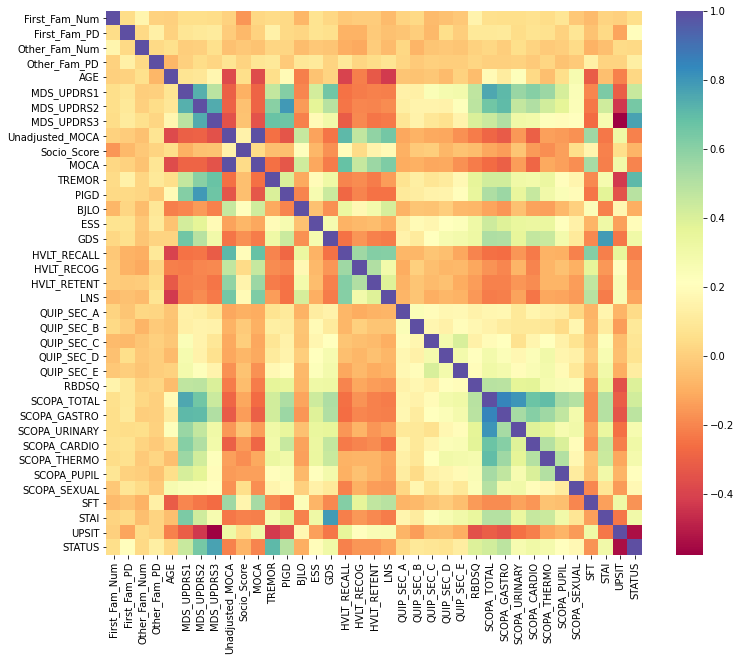

In [ ]:
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, cmap=plt.cm.Spectral)
plt.show()

In [ ]:
print("IMPORTANT FEATURES")
print()
for i in range(input_columns):
    corr1, _ = spearmanr(X[:,i], y[:, 0])
    corr2, _ = pearsonr(X[:,i], y[:, 0])
    if(abs(corr1) > 0.25 or abs(corr2) > 0.25 ):
        print(df.columns[i]+":\t\t",'Spearmans correlation: %.3f' % abs(corr1), 'Pearsons correlation: %.3f' % abs(corr2) )
print()

print("REDUNDANT FEATURES")
print()
for i in range(input_columns):
    corr1, _ = spearmanr(X[:,i], y[:, 0])
    corr2, _ = pearsonr(X[:,i], y[:, 0])
    if(abs(corr1)< 0.1 or abs(corr2) < 0.1 ):
        print(df.columns[i]+":\t\t",'Spearmans correlation: %.3f' % abs(corr1), 'Pearsons correlation: %.3f' % abs(corr2) )
print()

IMPORTANT FEATURES

MDS_UPDRS1:		 Spearmans correlation: 0.544 Pearsons correlation: 0.478
MDS_UPDRS2:		 Spearmans correlation: 0.762 Pearsons correlation: 0.651
MDS_UPDRS3:		 Spearmans correlation: 0.771 Pearsons correlation: 0.768
TREMOR:		 Spearmans correlation: 0.754 Pearsons correlation: 0.722
PIGD:		 Spearmans correlation: 0.701 Pearsons correlation: 0.492
GDS:		 Spearmans correlation: 0.403 Pearsons correlation: 0.323
RBDSQ:		 Spearmans correlation: 0.438 Pearsons correlation: 0.439
SCOPA_TOTAL:		 Spearmans correlation: 0.516 Pearsons correlation: 0.458
SCOPA_GASTRO:		 Spearmans correlation: 0.590 Pearsons correlation: 0.513
SCOPA_URINARY:		 Spearmans correlation: 0.320 Pearsons correlation: 0.306
SCOPA_CARDIO:		 Spearmans correlation: 0.440 Pearsons correlation: 0.341
SCOPA_THERMO:		 Spearmans correlation: 0.336 Pearsons correlation: 0.300
STAI:		 Spearmans correlation: 0.336 Pearsons correlation: 0.312
UPSIT:		 Spearmans correlation: 0.582 Pearsons correlation: 0.562

REDUNDAN